<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Feature Selection (FS) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1; text-align: center;">
    Required Imports
</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1; ">
    Package Descriptions
</h3>
<ul style="font-family: 'Arial', sans-serif; line-height: 1.8;">
    <li><strong>pandas</strong>: For data manipulation and analysis, allowing easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: For creating basic plots and data visualizations.</li>
    <li><strong>seaborn</strong>: For creating more attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand the dataset's quality.</li>
</ul>


In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
from scipy import stats # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.linear_model import LassoCV, RidgeCV, Ridge, ElasticNetCV, ElasticNet # type: ignore

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import sys
import os

sys.path.append(os.path.abspath("../utils"))
from models import monitor_model_rfe


import warnings
warnings.filterwarnings("ignore")

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section loads the dataset into the environment for further analysis and processing. By utilizing <code>pandas</code>, we can efficiently read and manipulate data, allowing for seamless integration in the analysis pipeline.
</p>


In [2]:
path = "../results/data/"

data_train = pd.read_csv(path + "data_train_post_PTD.csv")
data_test = pd.read_csv(path + "data_test_post_PTD.csv")

combined_data = pd.concat([data_train, data_test], keys=['train', 'test'])

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Partition and Data Scaling
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this section, we partition the dataset into training and testing subsets to evaluate model performance effectively. Additionally, data scaling is applied to normalize features, ensuring that all variables contribute equally to the model without being impacted by differing scales. This step is crucial for algorithms sensitive to feature magnitudes, such as regression and distance-based models.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Partition
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data partitioning is the process of dividing the dataset into training and testing subsets. The training set is used to fit and tune the model, while the testing set evaluates the model's generalization performance on unseen data. Proper partitioning helps prevent overfitting and provides a more reliable assessment of model effectiveness.
</p>


In [3]:
X = data_train.drop(columns=['Claim Identifier', 'Claim Injury Type'], axis = 1)
y = data_train['Claim Injury Type']

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
for i in X_train.select_dtypes(include=['number']).columns:
    X_train[i].fillna(0, inplace=True)

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data scaling is an essential preprocessing step to standardize the range of independent variables. By scaling features, we ensure that all variables contribute equally to model training, avoiding bias toward features with larger scales. Scaling is particularly important for algorithms sensitive to feature magnitudes, such as gradient-based methods and distance-based models.
</p>


In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Feature Selection Results
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section presents the results of the feature selection process, highlighting the most relevant variables for predicting the target outcome. By reducing dimensionality, we aim to enhance model performance, decrease overfitting, and improve interpretability. Selected features are retained for model training, while less informative variables are removed.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Filter Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Filter methods are a feature selection approach that assesses each feature's relevance based on statistical measures. These methods are computationally efficient and independent of the machine learning model, making them ideal for initial feature selection. Common techniques include correlation scores, chi-square tests, and mutual information, which help identify the most informative variables for model training.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Univariate Variables
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Univariate analysis focuses on examining each variable individually to understand its distribution, central tendency, and spread. This approach is useful for identifying basic patterns and outliers within single features, and it provides insights into which variables may have a significant impact on the target outcome. Univariate analysis is often the first step in exploratory data analysis and feature selection.
</p>


In [7]:
zero_variance_columns = X_train_scaled.var() == 0
zero_variance_columns_list = X_train_scaled.columns[zero_variance_columns].tolist()

print("Colunas com variância igual a zero:", zero_variance_columns_list)

Colunas com variância igual a zero: ['missing_Assembly Date']


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Correlation Indices
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Correlation indices measure the strength and direction of relationships between variables, helping to identify pairs of features that may have linear dependencies. High correlation values (positive or negative) indicate a strong relationship, which can guide feature selection by revealing redundant variables. Analyzing these indices aids in understanding interactions within the dataset and optimizing model performance.
</p>


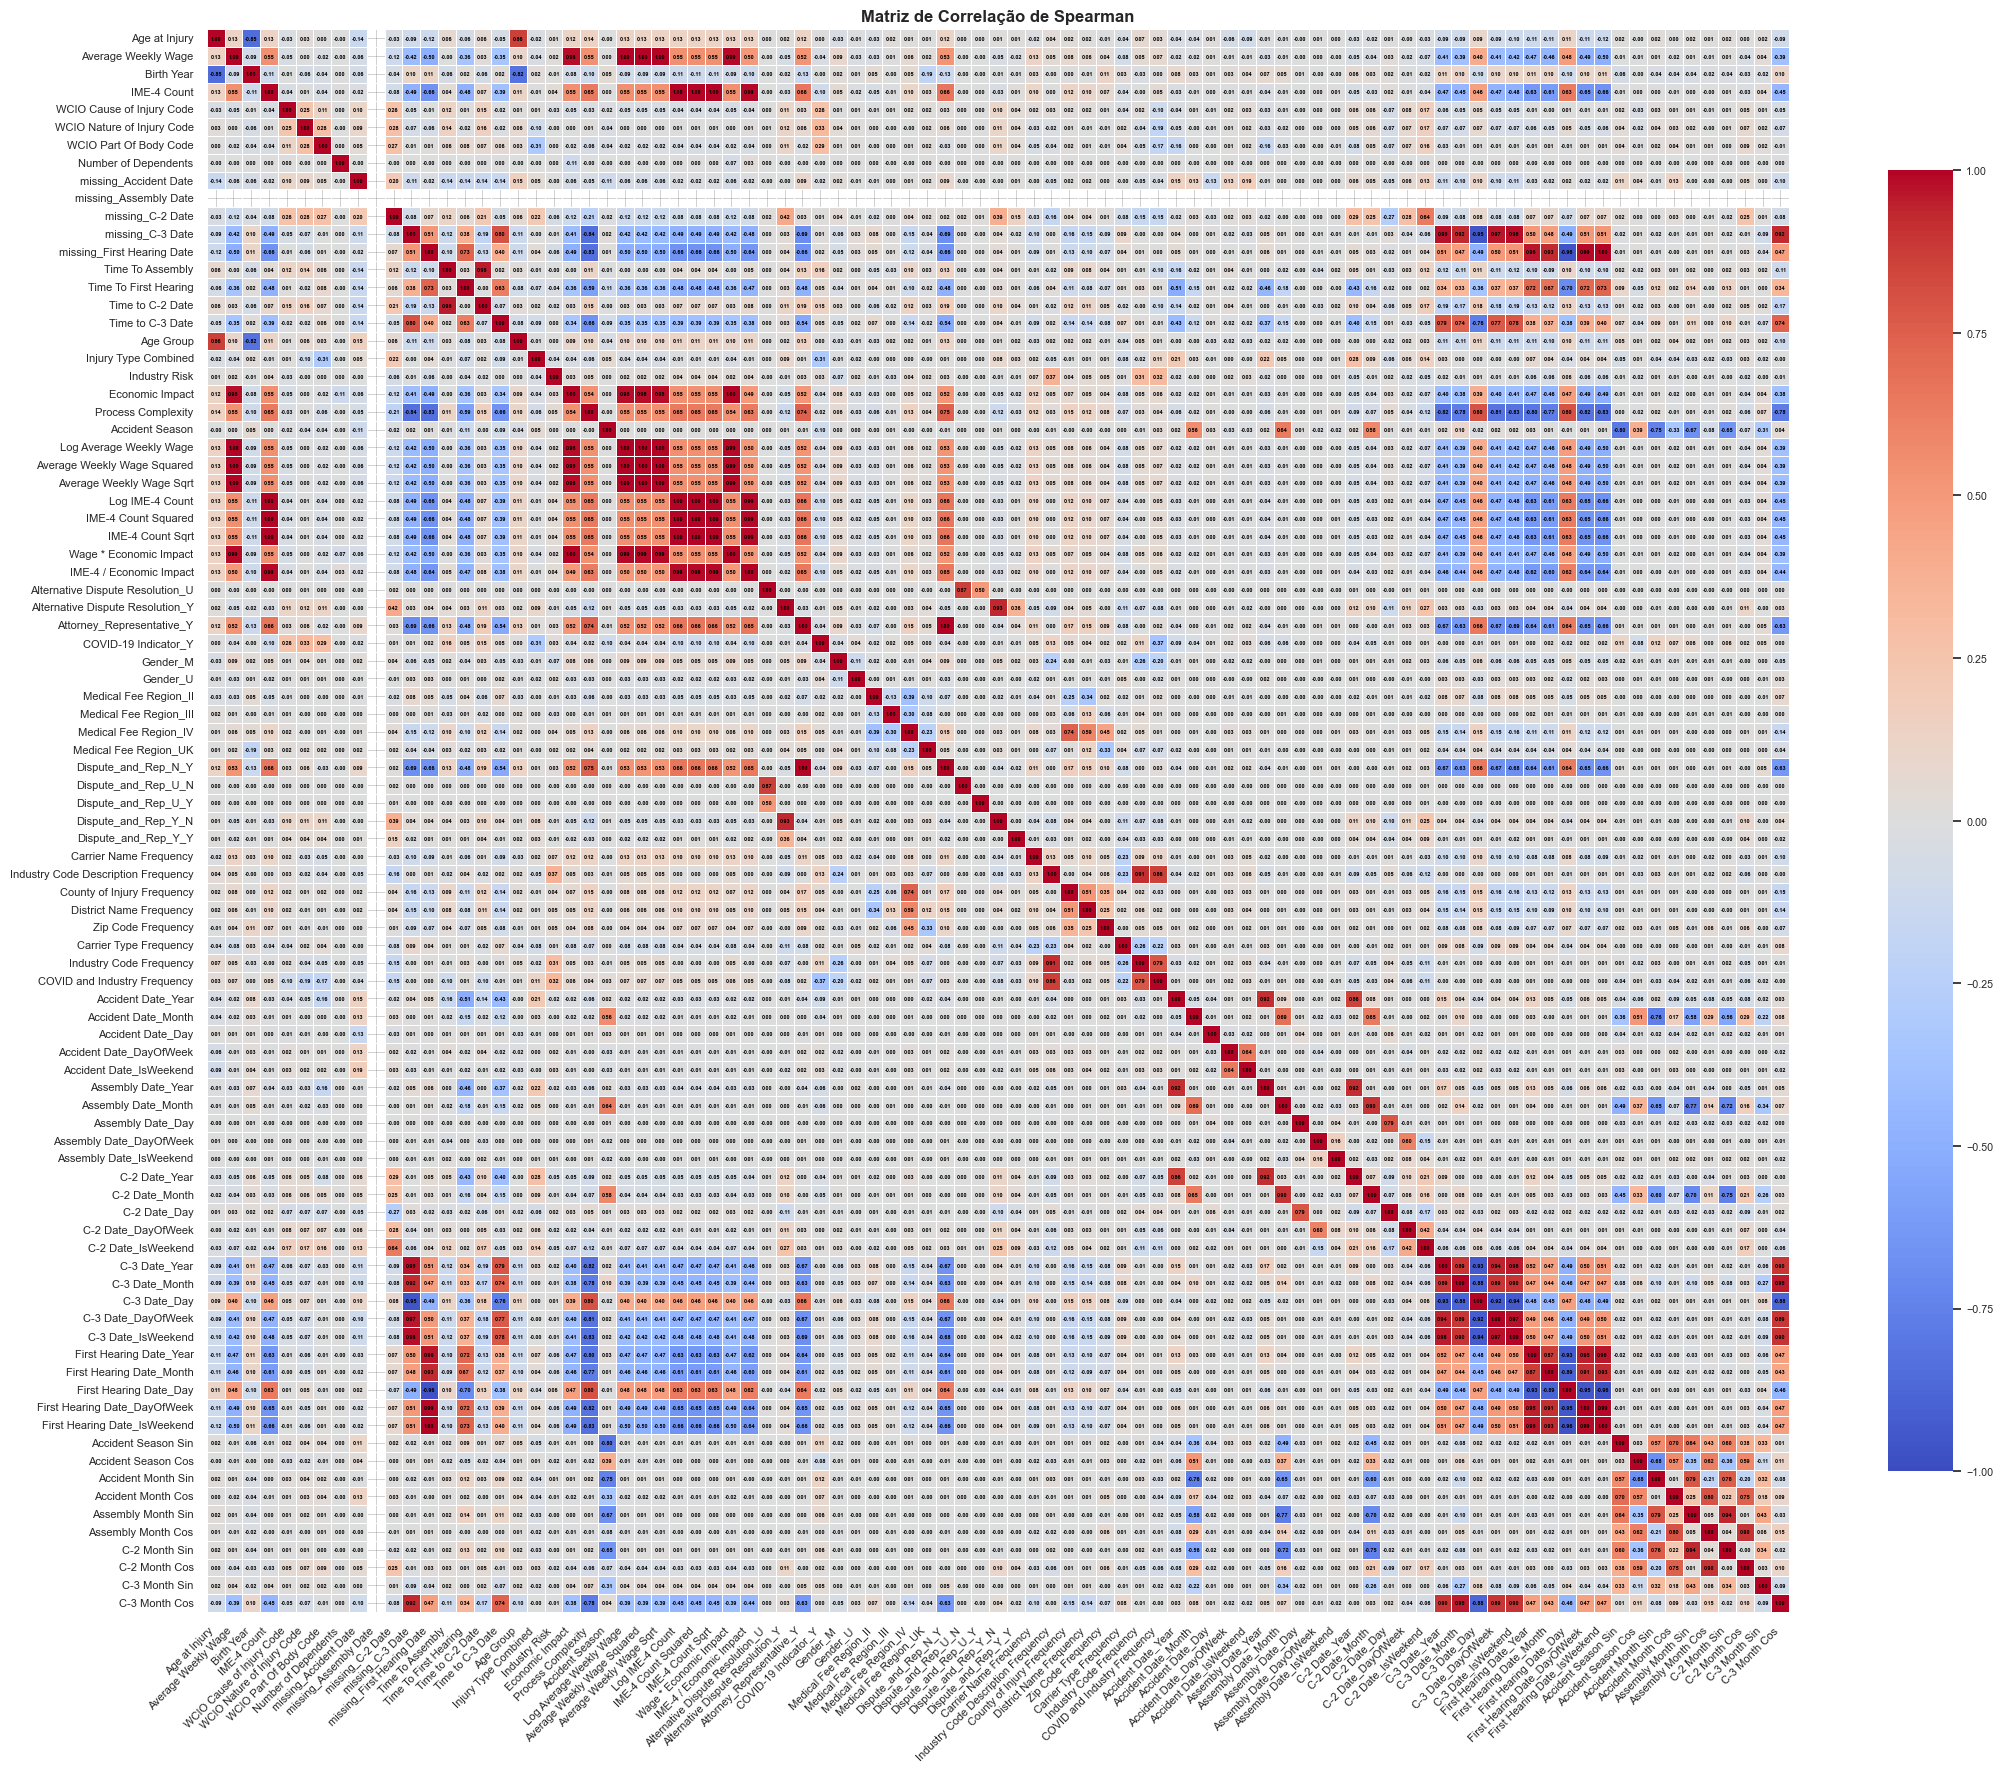

In [8]:
cor_spearman = X_train_scaled.corr(method='spearman')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(cor_spearman,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 4, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Spearman', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

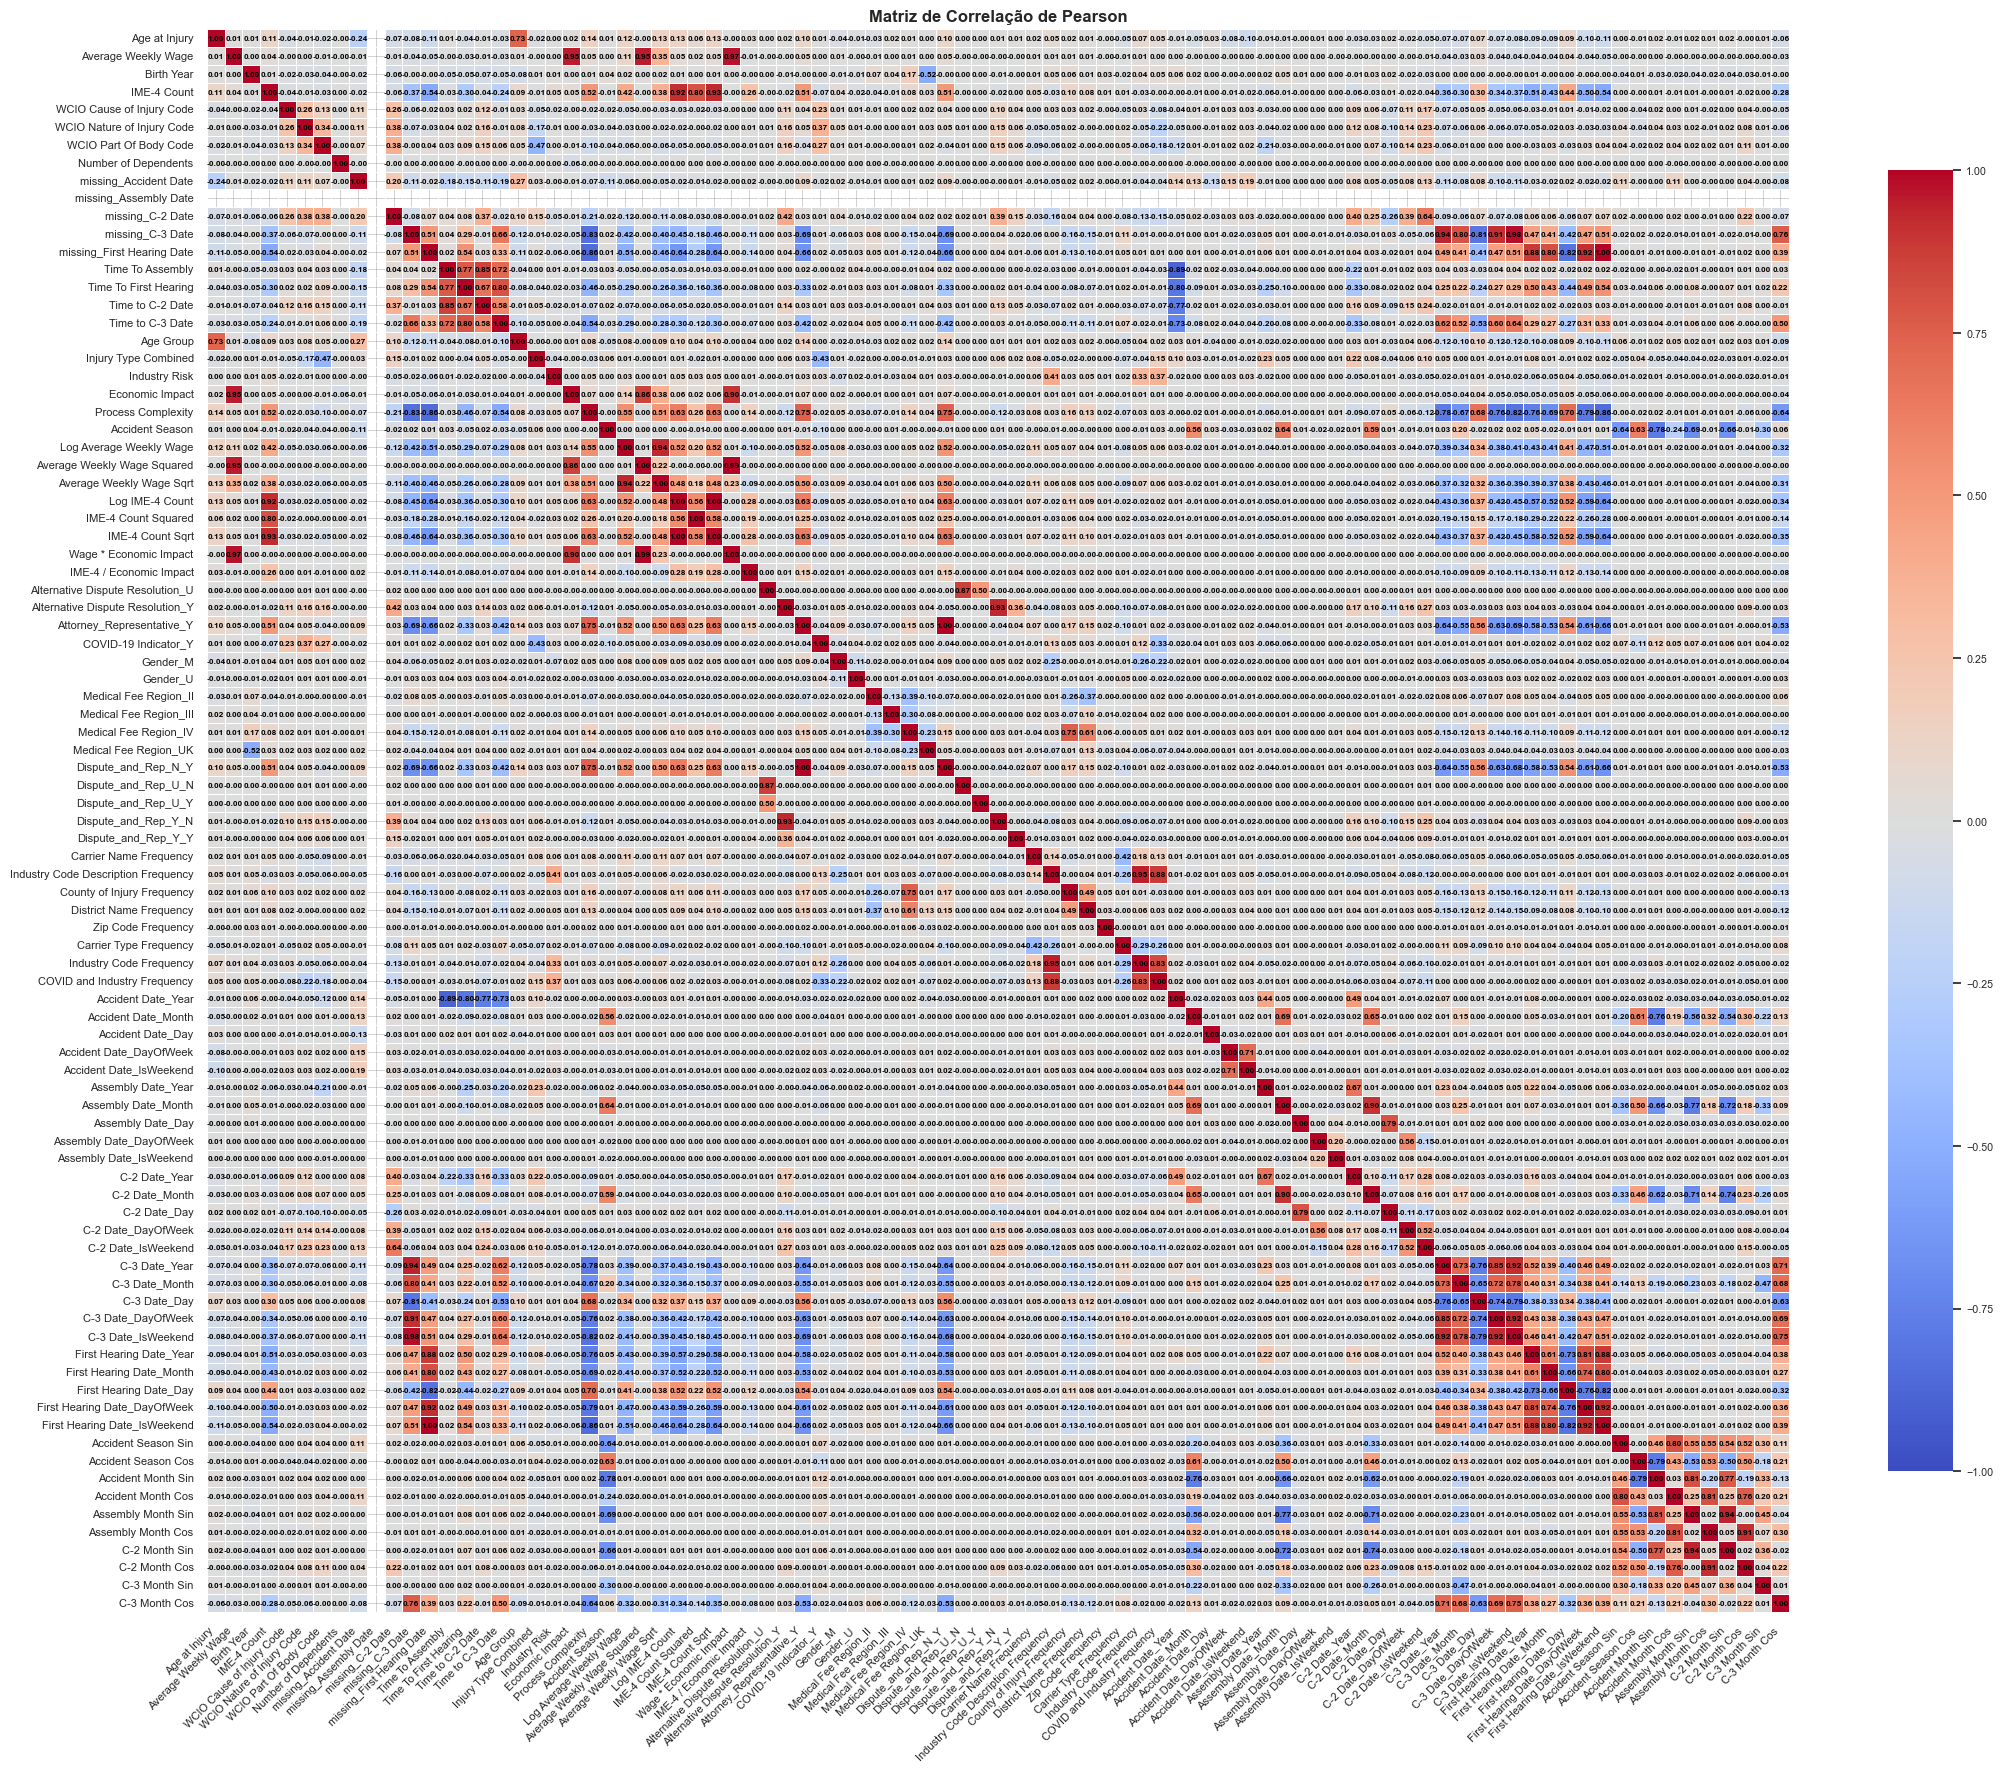

In [9]:
corr_pearson = X_train_scaled.corr(method='pearson')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(corr_pearson,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 6, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Pearson', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

<h1 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Wrapper Methods for Feature Selection (RFE -> Recursive Feature Elimination)
</h1>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Logistic Regression
</h2>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> RFE with Logistic Regression systematically eliminates variables with the least predictive power, reducing dimensionality and enhancing model focus.</li>
    <li><strong>How It Works:</strong> RFE recursively fits the logistic regression model, removing weaker features based on model weights until an optimal subset is reached.</li>
</ul>

In [10]:
log_reg = LogisticRegression(max_iter=1,random_state=42, verbose=1)

In [11]:
monitor_model_rfe(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, patience=8, nof_list=np.arange(10, X_train_scaled.shape[1] + 1, 10), nof=None, log_file="rfe_logistic.txt", output_csv="LogisticRegression.csv")

Feature Selection Progress: 100%|██████████| 8/8 [02:46<00:00, 20.79s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_logistic.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\LogisticRegression.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Decision Tree Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Decision Tree Classifier</strong> builds a tree-like model by splitting data based on feature values. It can rank features based on their importance scores, which represent each feature’s contribution to classifying instances.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Robust to non-linear relationships, decision trees handle both categorical and continuous variables, making them useful for discovering redundant features.</li>
    <li><strong>How It Works:</strong> The classifier splits data into branches, with higher importance assigned to features yielding significant information gain.</li>
</ul>

In [17]:
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

In [19]:
monitor_model_rfe(dt_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(10,  X_train_scaled.shape[1] + 1, 10), nof=None, log_file="rfe_dt.txt", output_csv="DecisionTree.csv")

Feature Selection Progress: 100%|██████████| 8/8 [23:26<00:00, 175.84s/features]


Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_dt.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\DecisionTree.csv



<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Decision Tree Regressor
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Decision Tree Regressor</strong> is a regression-based tree model for continuous target variables. It ranks features by importance for predicting numerical outcomes.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Useful for identifying non-linear relationships, aiding in the removal of features with low predictive relevance.</li>
    <li><strong>How It Works:</strong> The regressor splits data, assigning importance based on how well features predict continuous target values.</li>
</ul>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Random Forest Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Random Forest Classifier</strong> is an ensemble method combining multiple decision trees to enhance classification accuracy. It provides robust feature importance scores for feature selection.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Its ensemble nature offers reliable importance metrics, especially useful for high-dimensional data.</li>
    <li><strong>How It Works:</strong> Importance is derived by examining split frequency and quality across multiple trees.</li>
</ul>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     XGBoost
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <strong>XGBoost</strong> (Extreme Gradient Boosting) builds trees sequentially to improve accuracy, providing robust feature importance metrics based on feature contributions to split quality.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> XGBoost’s efficiency with large datasets and high-dimensional data makes it ideal for advanced feature selection.</li>
    <li><strong>How It Works:</strong> Tracks gain from splits involving each feature, allowing less informative features to be eliminated.</li>
</ul>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     LightGBM
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <strong>LightGBM</strong> (Light Gradient Boosting Machine) is optimized for speed and memory efficiency. Like XGBoost, it uses boosting but is faster and more resource-efficient.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> LightGBM’s efficient handling of large datasets and accurate importance metrics are ideal for scalable feature selection.</li>
    <li><strong>How It Works:</strong> It assesses feature importance by tracking split quality and frequency, eliminating less informative features for a streamlined model.</li>
</ul>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; text-align: center;">
    These algorithms are chosen for their robustness in complex data and ability to directly evaluate feature importance, making them ideal for wrapper-based feature selection.
</p>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Conclusion
</h2>

<p style=" font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Due to the large number of columns and the size of the dataset, running these algorithms would be very time-consuming. Since the process is intended to be efficient and resource-light, we opted not to apply them to the entire dataset. Instead, during testing, we evaluated all these models on 10% of the dataset. This approach allowed us to understand their functionality and benefits without excessive resource usage.
</p>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Embedded Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Embedded methods perform feature selection as part of the model training process, automatically identifying important features based on the model's performance. These methods strike a balance between filter and wrapper approaches, offering efficiency while considering feature interactions. Common algorithms, such as regularization techniques (e.g., Lasso and Ridge) and tree-based methods, are often used to retain the most relevant features and eliminate those that add little value to predictive accuracy.
</p>


In [12]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Lasso Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that performs both variable selection and regularization. By adding a penalty equal to the absolute value of the coefficients, Lasso reduces some coefficients to zero, effectively removing less important features from the model.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Lasso is ideal for high-dimensional data, as it can simplify models by removing irrelevant features, leading to more interpretable and efficient models.</li>
    <li><strong>How It Works:</strong> Lasso applies an L1 regularization term that penalizes large coefficients, shrinking some to zero. Features with zeroed-out coefficients are effectively eliminated, preserving only the most predictive variables.</li>
</ul>


In [13]:
modelLassoRegression = LassoCV()
modelLassoRegression.fit(X_train_scaled, y_train)

coef_modelLassoRegression = pd.Series(modelLassoRegression.coef_, index = X_train_scaled.columns)
print("Lasso picked " + str(sum(coef_modelLassoRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelLassoRegression == 0)) + " variables")

plot_importance(coef_modelLassoRegression,'Lasso')

KeyboardInterrupt: 

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Ridge Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Ridge Regression is a linear regression method that includes an L2 regularization term, which penalizes the sum of the squared coefficients. Unlike Lasso, Ridge does not eliminate features by setting coefficients to zero but instead reduces the magnitude of all coefficients, particularly for features with minor predictive power.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Ridge Regression is effective in handling multicollinearity and reducing model complexity without discarding features, making it ideal for datasets with many correlated variables.</li>
    <li><strong>How It Works:</strong> The L2 penalty shrinks all coefficients proportionally, stabilizing the model and preventing overfitting, especially when dealing with high-dimensional data.</li>
</ul>


Ridge picked 88 variables and eliminated the other 1 variables


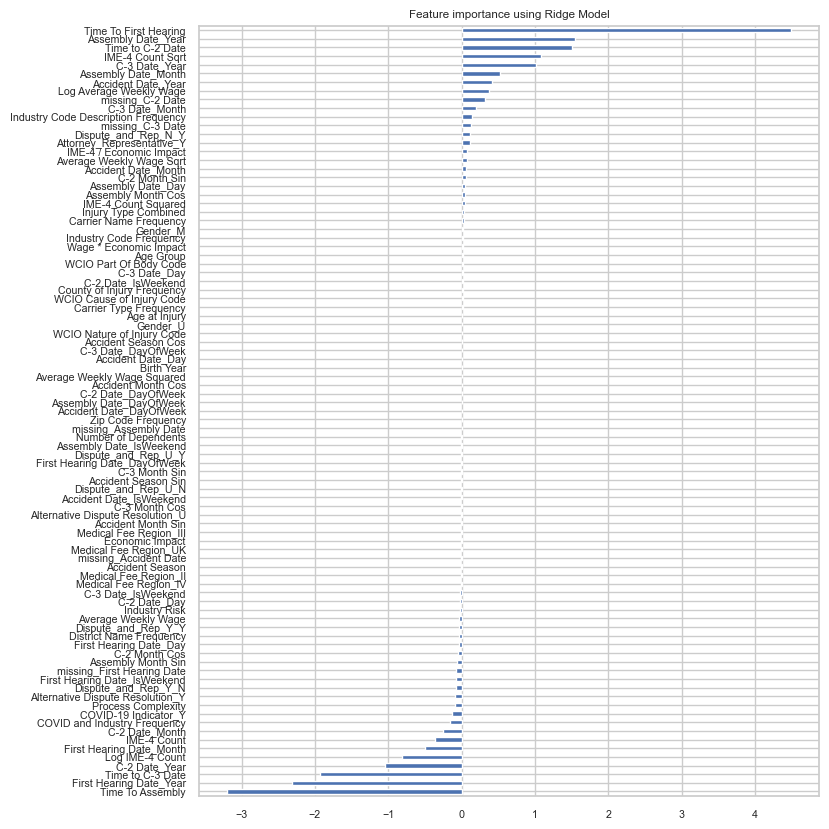

In [ ]:
modelRidgeRegressionCV = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
modelRidgeRegressionCV.fit(X_train_scaled, y_train)

best_alpha = modelRidgeRegressionCV.alpha_
modelRidgeRegression = Ridge(alpha=best_alpha)
modelRidgeRegression.fit(X_train_scaled, y_train)

coef_modelRidgeRegression = pd.Series(modelRidgeRegression.coef_, index = X_train_scaled.columns)
print("Ridge picked " + str(sum(coef_modelRidgeRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelRidgeRegression == 0)) + " variables")

plot_importance(coef_modelRidgeRegression,'Ridge')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Elastic Net
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Elastic Net is a regression technique that combines both L1 (Lasso) and L2 (Ridge) regularization penalties. It is particularly useful for datasets with highly correlated features, where it balances feature selection and coefficient shrinkage, preventing some limitations associated with Lasso and Ridge alone.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Elastic Net is effective in high-dimensional data where features are highly correlated, as it combines the strengths of Lasso and Ridge to improve feature selection and model stability.</li>
    <li><strong>How It Works:</strong> Elastic Net applies a weighted sum of the L1 and L2 penalties, allowing both feature elimination (Lasso effect) and coefficient shrinkage (Ridge effect) to enhance model accuracy and interpretability.</li>
</ul>


Elastic Net picked 0 variables and eliminated the other 89 variables


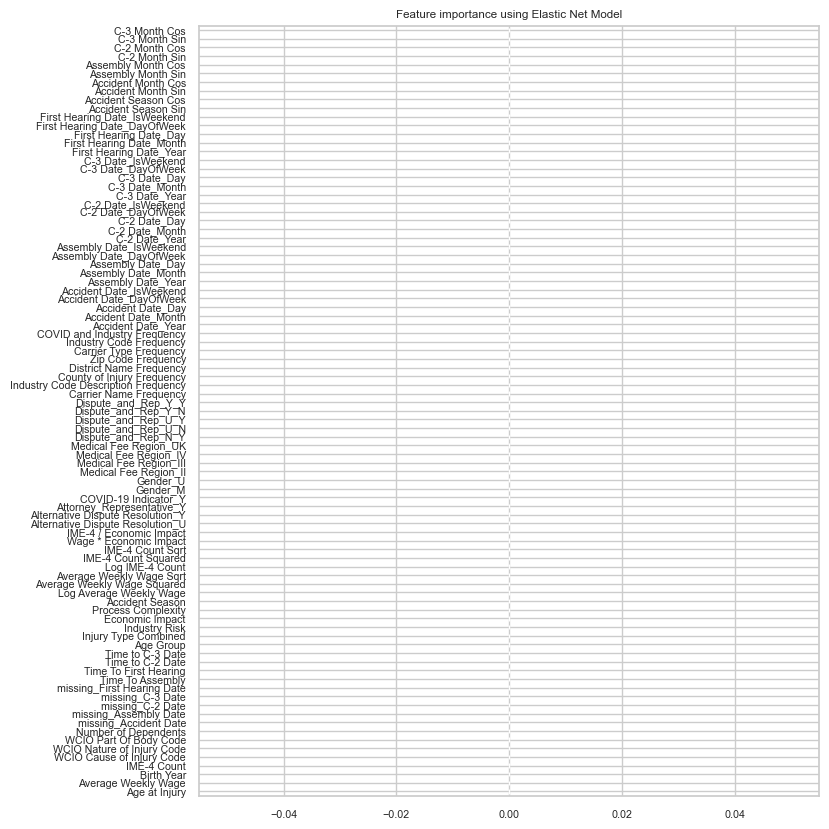

In [ ]:
modelElasticNetCv = ElasticNetCV(cv=5, random_state=42)
modelElasticNetCv.fit(X_train_scaled, y_train)

best_alpha = modelElasticNetCv.alpha_
best_l1_ratio = modelElasticNetCv.l1_ratio_

modelElasticNet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
modelElasticNet.fit(X_train_scaled, y_train)

coef_modelElasticNet = pd.Series(modelElasticNet.coef_, index = X_train_scaled.columns)
print("Elastic Net picked " + str(sum(coef_modelElasticNet != 0)) + " variables and eliminated the other " +  str(sum(coef_modelElasticNet == 0)) + " variables")

plot_importance(coef_modelElasticNet,'Elastic Net')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Final Variables Selected by Feature Selection
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    After applying various feature selection methods, the following variables were retained as the most relevant for predicting the target outcome. These features demonstrated significant predictive power, contributing meaningfully to model accuracy and interpretability, while minimizing model complexity.
</p>


In [ ]:
def mark_highly_correlated_features(data, isPearson, correlation_threshold = 0.8):

    if isPearson:
        corr_matrix = data.corr(method='pearson')
    else:
        corr_matrix = data.corr(method='spearman')

    correlation_decisions = {feature : 'keep' for feature in data.columns}

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation_value = corr_matrix.iloc[i, j]

            if abs(correlation_value) >= correlation_threshold:
                if correlation_decisions[feature1] == 'keep' and correlation_decisions[feature2] == 'keep':
                    if data[feature1].var() >= data[feature2].var():
                        correlation_decisions[feature2] = 'drop'
                    else:
                        correlation_decisions[feature1] = 'drop'

    return correlation_decisions

In [ ]:
all_features = X_train_scaled.columns

data_columns = { 'Feature': all_features }

correlation_decisions_pearson = mark_highly_correlated_features(X_train_scaled, True)
correlation_decisions_spearman = mark_highly_correlated_features(X_train_scaled, False)

data_columns['Univariate'] = ['keep' if float(val) != 0 else 'drop' for feature, val in X_train_scaled.var().to_dict().items()]
data_columns['Correlation(Pearson)'] = [correlation_decisions_pearson[feature] for feature in data_columns['Feature']]
data_columns['Correlation(Spearman)'] = [correlation_decisions_spearman[feature] for feature in data_columns['Feature']]

df_data_columns = pd.DataFrame(data_columns)
df_data_columns

,Feature,Univariate,Correlation(Pearson),Correlation(Spearman)
0,Age at Injury,keep,keep,keep
1,Average Weekly Wage,keep,keep,keep
2,Birth Year,keep,keep,drop
3,IME-4 Count,keep,drop,drop
4,WCIO Cause of Injury Code,keep,keep,keep
...,...,...,...,...
84,Assembly Month Cos,keep,drop,drop
85,C-2 Month Sin,keep,keep,keep
86,C-2 Month Cos,keep,keep,keep
87,C-3 Month Sin,keep,keep,keep


In [ ]:
data_columns_EM = {'Feature' : all_features}

df_lasso = pd.DataFrame({'Feature': all_features, 'Lasso Coefficient': coef_modelLassoRegression})
df_RidgeRegression = pd.DataFrame({'Feature': all_features, 'Ridge Coefficient': coef_modelRidgeRegression})
df_elasticnet = pd.DataFrame({'Feature': all_features, 'ElasticNet Coefficient': coef_modelElasticNet})

threshold = 0.05

data_columns_EM['Lasso Coefficient'] = df_lasso['Lasso Coefficient'].apply(lambda x: 'keep' if x != 0 else 'drop')
data_columns_EM['Ridge Coefficient'] = df_RidgeRegression['Ridge Coefficient'].apply(lambda x: 'keep' if abs(x) > threshold else 'drop')
data_columns_EM['ElasticNet Coefficient'] = df_elasticnet['ElasticNet Coefficient'].apply(lambda x: 'keep' if abs(x) > threshold else 'drop')

df_data_columns_EM = pd.DataFrame(data_columns_EM)
df_data_columns_EM.reset_index(drop=True, inplace=True)
df_data_columns_EM

,Feature,Lasso Coefficient,Ridge Coefficient,ElasticNet Coefficient
0,Age at Injury,drop,drop,drop
1,Average Weekly Wage,drop,drop,drop
2,Birth Year,drop,drop,drop
3,IME-4 Count,drop,keep,drop
4,WCIO Cause of Injury Code,drop,drop,drop
...,...,...,...,...
84,Assembly Month Cos,drop,drop,drop
85,C-2 Month Sin,drop,keep,drop
86,C-2 Month Cos,drop,keep,drop
87,C-3 Month Sin,drop,drop,drop


In [ ]:
def decision_based_on_models(row):
    keep_count = sum([1 if 'keep' == value else 0 for value in row])
    return 'keep' if keep_count >= 2 else 'drop'

In [ ]:
df_final_decision = pd.DataFrame({'Feature': all_features})

df_final_decision['Filter Methods Decision'] = df_data_columns.iloc[:, 1:].apply(decision_based_on_models, axis=1)
df_final_decision['Embedded Methods Decision'] = df_data_columns_EM.iloc[:, 1:].apply(decision_based_on_models, axis=1)

df_final_decision

,Feature,Filter Methods Decision,Embedded Methods Decision
0,Age at Injury,keep,drop
1,Average Weekly Wage,keep,drop
2,Birth Year,keep,drop
3,IME-4 Count,drop,drop
4,WCIO Cause of Injury Code,keep,drop
...,...,...,...
84,Assembly Month Cos,drop,drop
85,C-2 Month Sin,keep,drop
86,C-2 Month Cos,keep,drop
87,C-3 Month Sin,keep,drop


In [ ]:
def select_features(df):
    selected_features = []
    dropped_features = []

    for index, row in df.iterrows():
        decisions = [row['Filter Methods Decision'], row['Embedded Methods Decision']]
        keep_count = decisions.count('keep')

        if keep_count >= 1:
            selected_features.append(row['Feature'])
        else:
            dropped_features.append(row['Feature'])

    return selected_features, dropped_features

In [ ]:
final_features, dropped_features = select_features(df_final_decision)
print("Features selecionadas:", final_features)
print("Features descartadas:", dropped_features)

Features selecionadas: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'missing_Accident Date', 'missing_Assembly Date', 'missing_C-2 Date', 'Time To First Hearing', 'Time to C-2 Date', 'Age Group', 'Injury Type Combined', 'Industry Risk', 'Accident Season', 'Log Average Weekly Wage', 'Log IME-4 Count', 'IME-4 Count Squared', 'IME-4 / Economic Impact', 'Alternative Dispute Resolution_U', 'COVID-19 Indicator_Y', 'Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Dispute_and_Rep_N_Y', 'Dispute_and_Rep_U_Y', 'Dispute_and_Rep_Y_N', 'Dispute_and_Rep_Y_Y', 'Carrier Name Frequency', 'County of Injury Frequency', 'District Name Frequency', 'Zip Code Frequency', 'Carrier Type Frequency', 'Industry Code Frequency', 'COVID and Industry Frequency', 'Accident Date_Year', 'Accident Date_Month', 'Accident Date_Da

In [ ]:
combined_data.drop(columns=dropped_features, inplace=True)

In [ ]:
data_train = combined_data.loc['train'].reset_index(drop=True)
data_test = combined_data.loc['test'].reset_index(drop=True)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Download Dataset
</h2>
<hr style="border: 1px solid #4A90E2;">


In [ ]:
data_train.to_csv("../data/data_train_post_FS.csv", index=False)


In [ ]:
data_test.to_csv("../data/data_test_post_FS.csv", index=False)